In [1]:
!pip install torch
import torch

In [2]:
import torch.nn as nn
import torch.nn.functional as F

In [3]:
from torch_geometric.data import Data
from sklearn.preprocessing import StandardScaler

In [4]:
import torch.optim as optim

In [5]:
import networkx as nx

In [6]:
from heapq import nsmallest

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [8]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [9]:
from sklearn.metrics import r2_score

In [10]:
from torch_geometric.nn import GATConv

In [11]:
from sklearn.metrics import mean_absolute_percentage_error

Epoch [0/2000], Loss: 0.404220, MAE: 0.774461, RMSE: 0.998743, MSE: 0.997488, R²: 0.002512, MAPE: 1.017820
Early stopping at epoch 31


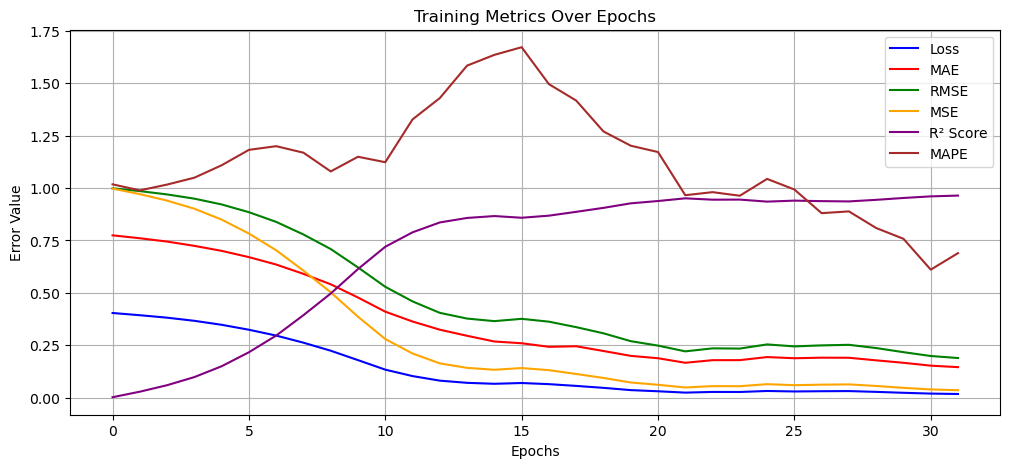


--------------------------------------------------


In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, output_dim=1, num_layers=2, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out


def prepare_data(traffic_data, location_data):
    node_features = traffic_data.groupby('location')[['flow', 'occupy', 'speed']].mean().values
    scaler = StandardScaler()
    node_features = scaler.fit_transform(node_features)
    target = traffic_data.groupby('location')['speed'].mean().values.reshape(-1, 1)
    target_scaler = StandardScaler()
    normalized_target = target_scaler.fit_transform(target)
    x = torch.tensor(node_features, dtype=torch.float).unsqueeze(1)
    y = torch.tensor(normalized_target, dtype=torch.float)
    return x, y, scaler, target_scaler


def train_model(model, x_train, y_train, epochs=2000, patience=12):
    optimizer = optim.AdamW(model.parameters(), lr=0.005, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)
    loss_fn = nn.SmoothL1Loss()  # Using Huber Loss
    best_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    model.train()

    # Lists to store metrics
    loss_list = []
    mae_list = []
    rmse_list = []
    mse_list = []
    r2_list = []
    mape_list = []

    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(x_train)
        loss = loss_fn(output, y_train)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient Clipping
        optimizer.step()
        scheduler.step()

        # Compute MAE, RMSE, MSE, R², and MAPE
        predicted = output.detach().cpu().numpy()
        actual = y_train.detach().cpu().numpy()
        mae = mean_absolute_error(actual, predicted)
        rmse = np.sqrt(mean_squared_error(actual, predicted))
        mse = mean_squared_error(actual, predicted)
        r2 = r2_score(actual, predicted)
        mape = mean_absolute_percentage_error(actual, predicted)

        # Store values for graph plotting
        loss_list.append(loss.item())
        mae_list.append(mae)
        rmse_list.append(rmse)
        mse_list.append(mse)
        r2_list.append(r2)
        mape_list.append(mape)

        if loss.item() < best_loss:
            best_loss = loss.item()
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            model.load_state_dict(best_model_state)
            break

        if epoch % 100 == 0:
            print(f'Epoch [{epoch}/{epochs}], Loss: {loss.item():.6f}, MAE: {mae:.6f}, RMSE: {rmse:.6f}, MSE: {mse:.6f}, R²: {r2:.6f}, MAPE: {mape:.6f}')

        if epoch > 30:
            print(f"Early stopping at epoch {epoch}")
            model.load_state_dict(best_model_state)
            break

    # Plot loss, MAE, RMSE, MSE, R², and MAPE
    plt.figure(figsize=(12, 5))
    plt.plot(loss_list, label="Loss", color='blue')
    plt.plot(mae_list, label="MAE", color='red')
    plt.plot(rmse_list, label="RMSE", color='green')
    plt.plot(mse_list, label="MSE", color='orange')
    plt.plot(r2_list, label="R² Score", color='purple')
    plt.plot(mape_list, label="MAPE", color='brown')
    plt.xlabel("Epochs")
    plt.ylabel("Error Value")
    plt.title("Training Metrics Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

    return model


def calculate_top_k_paths(graph, start_node, end_node, top_k=5):
    try:
        paths = nx.shortest_simple_paths(graph, source=start_node, target=end_node, weight='weight')
        return nsmallest(top_k, ((path, sum(graph[u][v]['weight'] for u, v in zip(path, path[1:]))) for path in paths), key=lambda x: x[1])
    except nx.NetworkXNoPath:
        print("No path exists between the specified nodes.")
        return []


def adjust_speed_with_flow(speed, flow, max_flow):
    return speed * (1 - flow / max_flow)


def predict_and_calculate_eta(graph, traffic_data, target_scaler, model_output, paths):
    max_flow = traffic_data['flow'].max()
    predicted_results = []
    actual_results = []
    predicted_speeds = []
    actual_speeds = []

    for path, distance in paths:
        avg_predicted_speed = np.mean([
            adjust_speed_with_flow(
                target_scaler.inverse_transform(model_output[int(node)].detach().numpy().reshape(1, -1))[0][0],
                traffic_data.loc[traffic_data['location'] == node, 'flow'].mean(),
                max_flow
            ) for node in path
        ])
        predicted_eta = distance / max(avg_predicted_speed, 1e-6)
        predicted_results.append((path, predicted_eta, distance, avg_predicted_speed))
        predicted_speeds.append(avg_predicted_speed)

        avg_actual_speed = np.mean([
            adjust_speed_with_flow(
                traffic_data.loc[traffic_data['location'] == node, 'speed'].mean(),
                traffic_data.loc[traffic_data['location'] == node, 'flow'].mean(),
                max_flow
            ) for node in path
        ])
        actual_eta = distance / max(avg_actual_speed, 1e-6)
        actual_results.append((path, actual_eta, distance, avg_actual_speed))
        actual_speeds.append(avg_actual_speed)

    plt.figure(figsize=(10, 6))
    plt.plot(predicted_speeds, label='Predicted Speed', color='red')
    plt.plot(actual_speeds, label='Actual Speed', color='green')
    plt.xlabel('Paths')
    plt.ylabel('Speed (km/h)')
    plt.title('Actual vs Predicted Speed')
    plt.legend()
    plt.grid(True)
    plt.show()
    return predicted_results, actual_results


def main():
    traffic_data = pd.read_csv("Traffic.csv")
    location_data = pd.read_excel("Location_Weight.xlsx")
    x_train, y_train, feature_scaler, target_scaler = prepare_data(traffic_data, location_data)
    model = LSTMModel(input_dim=3, hidden_dim=128)
    model = train_model(model, x_train, y_train)

    G = nx.DiGraph()
    for _, row in location_data.iterrows():
        G.add_edge(row['From'], row['To'], weight=row['Distance (km)'])

    while True:
        print("\n" + "-"*50)
        start_node = int(input("Enter the starting node (or type -1 to exit): "))
        if start_node == -1:
            break
        end_node = int(input("Enter the ending node: "))
        top_k = 5
        top_paths = calculate_top_k_paths(G, start_node, end_node, top_k=top_k)

        model.eval()
        with torch.no_grad():
            model_output = model(x_train)

        predicted_results, actual_results = predict_and_calculate_eta(G, traffic_data, target_scaler, model_output, top_paths)

        print(f"\nRoute {start_node} → {end_node}:")
        for i, (path, eta, distance, predicted_speed) in enumerate(predicted_results, 1):
            print(f"{i}. Path: {' → '.join(map(str, path))}, ETA: {eta:.4f} hours ({eta * 60:.1f} minutes), Distance: {distance:.2f} km, Predicted Speed: {predicted_speed:.2f} km/h")

        print("\n")

        print("Actual Paths:")
        for i, (path, eta, distance, actual_speed) in enumerate(actual_results, 1):
            print(f"{i}. Path: {' → '.join(map(str, path))}, ETA: {eta:.4f} hours ({eta * 60:.1f} minutes), Distance: {distance:.2f} km, Actual Speed: {actual_speed:.2f} km/h")


if __name__ == "__main__":
    main()